# Golgi Polarization at Wound Edge

The Golgi responds to experimental wounding by reorientating ("polarizing") at the wound edge.

This is an exploratory analysis with the goal of obtaining data such as Golgi orientation angle, Golgi perimeter, Golgi area, the animal it came from, how many hours it's been, etc.

1. Use the 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib.colors as colors

### Ensuring pretty plots ###
plt.style.use('ggplot')
plt.rc('axes', titlesize = 22)
plt.rc('axes', labelsize = 22)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

## Importing tiff stacks into Python


We use `skimage.io.imread()` to load tiff files containing three 16-bit channels (**Green, Blue, Red**). Respectively, they show **Golgi, cell nuclei, and cadherin**.

Not all image readers can understand tiffs with multiple images. RGB image loaders frequently assume that your image is 8-bit where your values range 0 to 255. 


dtype:uint16, shape:(2044, 2048, 3), min:0, max:17180


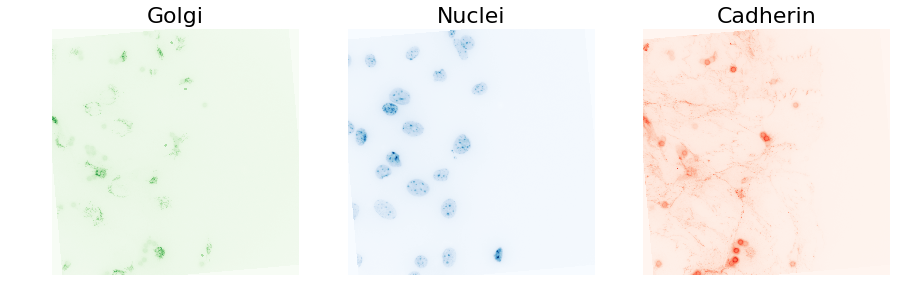

In [ ]:
### Importing tiff stack images with skimage.io.imread
from skimage import io

imdir = 'C:/Users/letmedoit/endothelial Polarization-exp 1/processeddata/Animal-1-4hrs-marked/'
imarrayGBR = io.imread(imdir+'Animal 1_4hrs_002-edit.tif')  # loads to numpy array

print("dtype:{}, shape:{}, min:{}, max:{}".format(
    imarrayGBR.dtype, imarrayGBR.shape, imarrayGBR.min(), imarrayGBR.max()))

### N.B. The order is green, blue, red
colors = ['Greens', 'Blues', 'Reds']
names = ['Golgi', 'Nuclei', 'Cadherin']

## Plotting under this line ##
fig, ax = plt.subplots(1, 3, figsize=(15,15))

for color in range(imarrayGBR.shape[2]):
    ax[color].imshow(imarrayGBR[:,:,color], cmap=colors[color])
    ax[color].set_title(names[color])
    ax[color].set_axis_off()

In [66]:
def showimage(imagearray, color='gray', title='', vmax=None):
    colorsandcmaps = {'gray':'gray', 'green':'Greens',
                      'blue':'Blues', 'red':'Reds'}
    plt.figure(figsize=(9,9))
    plt.imshow(imagearray,
               vmax = vmax,
               cmap = colorsandcmaps[color])
    plt.xlabel('Pixel [x]')
    plt.ylabel('Pixel [y]')
    plt.title(title)
    plt.colorbar()

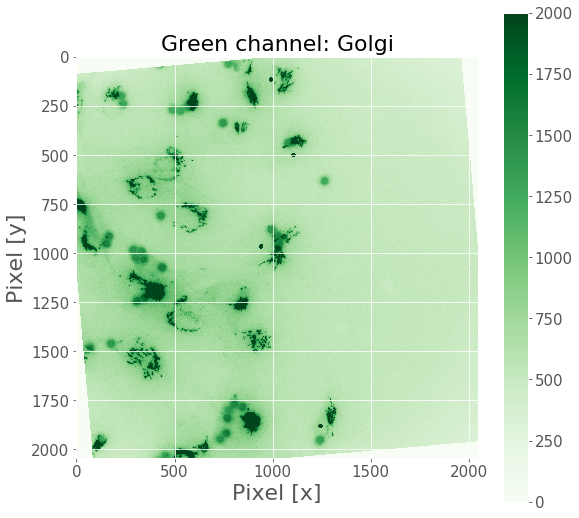

In [67]:
# The first image in the tif stack is green
imarray = imarrayGBR[:,:,0] 

showimage(imarray, color='green', title='Green channel: Golgi', vmax=2000)

## ROI designation

Cynthia marked cells along the wound edge since these would be the ones to re-orient. The Fiji spray paint tool creates circles (assuming the mouse is held down enough) with a specific pixel intensity. __Unfortunately, the specific pixel intensity varies between images.__

By inspection, we note that the spray can value varies between 1500 and 3500. 

Text(0,0.5,'Pixel [y]')

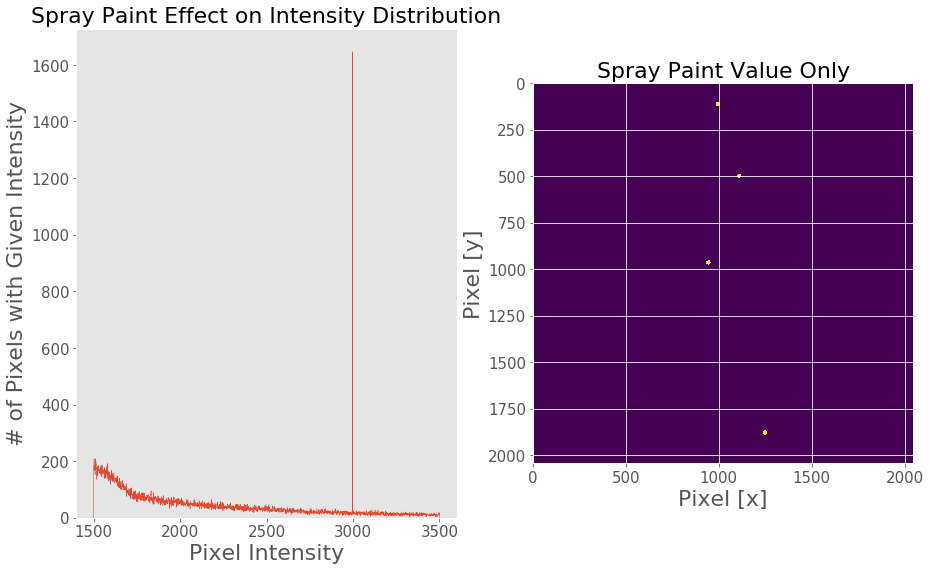

In [68]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

n, bins, _ = ax[0].hist(imarray.flatten(),
                            range=(1500,3500),
                            bins=2000,
                            histtype='step')

ax[0].set_xlabel('Pixel Intensity')
ax[0].set_ylabel('# of Pixels with Given Intensity')
ax[0].set_title('Spray Paint Effect on Intensity Distribution')
ax[0].grid('off')

# Within the range (1500,3500), the spray-can intensity
# is found the most and can be selected this way  
sprayvalue = int(bins[n.argmax()])

# mask to select pixels matching spray-can value
sprayarray = imarray == sprayvalue

ax[1].imshow(sprayarray)

ax[1].set_title('Spray Paint Value Only')
ax[1].set_xlabel('Pixel [x]')
ax[1].set_ylabel('Pixel [y]')

In [69]:
def getSprayCanValue(greenimagearray, pixelrange=(1500,3500)):
    """Returns [int], the most probable pixel intensity for spraycan
    
    Keyword arguments
    --------------------    
    greenimagearray [2D array]
        The image channel (green) marked with spraycan
        
    pixelrange [tuple]
        The range of intensity values.
        Make sure your range avoids the absolute maxima
    
    
    """
    imarray = np.array(greenimagearray)
    
    n, bins, _ = ax[0].hist(imarray.flatten(),
                            range=pixelrange,
                            bins=pixelrange[1]-pixelrange[0]
                           )
    sprayvalue = int(bins[n.argmax()])
    
    return sprayvalue

We can make a binary image to really see the spray painted values.

Currently `sprayarray` is a 2D boolean array. We want to get the indices where the values are True, and we'll use the indices as (x,y) pairs for cluster analysis. 

In [70]:
x,y = np.where(sprayarray==True)
X = np.array((x,y)).T

print('X.shape: {}'.format(X.shape))
print('X: {}'.format(X))

X.shape: (1646, 2)
X: [[ 103  988]
 [ 103  989]
 [ 103  990]
 ..., 
 [1890 1248]
 [1890 1249]
 [2018  556]]


### Determine amount of cells with DBSCAN

DBSCAN requires two parameters
- $\epsilon$, the maximum distance between two samples for them to be considered as in the same neighborhood
- `min_samples`, the number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself

Noise is removed in a well-defined manner.

In [71]:
## Thanks to dbscan documentation
## http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

from sklearn.cluster import DBSCAN
db = DBSCAN(eps=50, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)

print('Estimated number of clusters: {}'.format(n_clusters_))
print('Unique labels: {}'.format(unique_labels))

Estimated number of clusters: 4
Unique labels: {0, 1, 2, 3, -1}


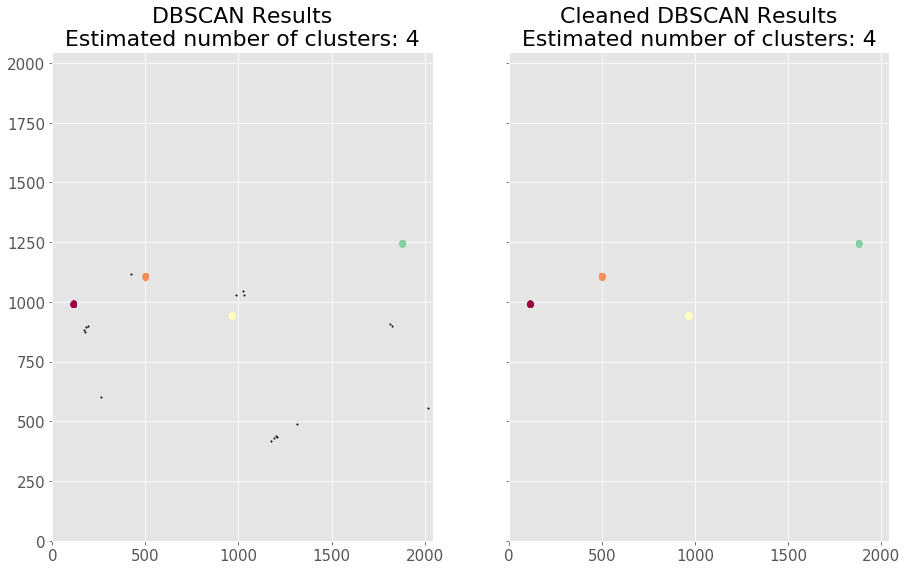

In [72]:
fig, ax = plt.subplots(1,2, figsize=(15,9),sharex=True,sharey=True)

spraypaintcenters = []
maxspraysize = 60 #pixels
# the actual sprays are ~21 pixels wide, so this is generous

colors = [plt.cm.Spectral(each)
         for each in np.linspace(0,1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    
    xy = X[class_member_mask & core_samples_mask]
    ax[0].plot(xy[:,0], xy[:,1], 'o', markerfacecolor=tuple(col),
        markeredgecolor=tuple(col), markersize=1)
    
    if k != -1:        # Ignore noise
        dx = np.max(xy[:,0]) - np.min(xy[:,0])
        dy = np.max(xy[:,1]) - np.min(xy[:,1])
        #print(dx, dy)
        if max(dx,dy) < maxspraysize:
            ax[1].plot(xy[:,0], xy[:,1], 'o', markerfacecolor=tuple(col),
            markeredgecolor=tuple(col), markersize=1)
            
            spraypaintcenters.append(
                [np.rint( np.min(xy[:,0]) + dx/2)  ,
                 np.rint( np.min(xy[:,1]) + dy/2)])
        else:
            badlabels.append(k)    

    xy = X[class_member_mask & ~core_samples_mask]
    ax[0].plot(xy[:,0], xy[:,1], 'o', markerfacecolor='k',
            markeredgecolor='k', markersize=1)
    
    
ax[0].set_xlim([0, imarray.shape[0]])
ax[0].set_ylim([0, imarray.shape[1]])

ax[0].set_title(
    'DBSCAN Results\nEstimated number of clusters: {}'.format(
    n_clusters_))
ax[1].set_title(
    'Cleaned DBSCAN Results\nEstimated number of clusters: {}'.format(
    n_clusters_))

spraypaintcenters = np.array(spraypaintcenters).astype(int)

If you're paying attention, you'll realize that this plot looks similar to the previous image.
The origin for this plot is lower-left while the origin for the image is at the upper-left. This is a minor annoyance and can be managed; let's demonstrate that we understand how to go back to an image.

Text(0,0.5,'Pixel [y]')

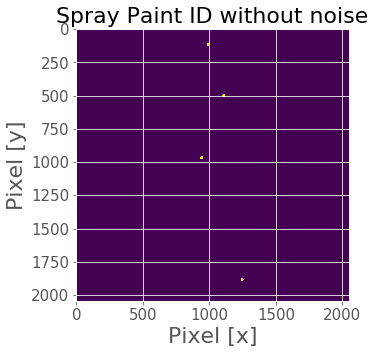

In [73]:
good_labels = ~np.in1d(labels, badlabels)
good_X = X[good_labels]

tobefilled = np.zeros_like(sprayarray)
tobefilled[good_X[:,0], good_X[:,1]] = 1
tobefilled = np.rot90(tobefilled, 0)

## Plotting under this line ##
plt.figure(figsize=(5,5))

plt.imshow(tobefilled)

plt.title('Spray Paint ID without noise')
plt.xlabel('Pixel [x]')
plt.ylabel('Pixel [y]')

In [74]:
def getROIpixels(imagearray, center, ROIside=222):
    """Return a box section of your original image array 
    
    Keyword arguments
    --------------------
    imagearray: [array]
        The image array to be sectioned
        
    center: [list] or [tuple] 
        pixel coordinates of ROI centroid given as either 
        a list [x,y] or a tuple (x,y)  
        
    ROIside: [int] (default: 222 pixels)
        side length in pixels of desired box 
    """
    assert ROIside % 2 == 0, "Give an even ROIside"
    
    # Make a copy instead of referencing original
    newimage = np.array(imagearray)
    
    halfside = ROIside/2
    x = center[0]
    y = center[1]
    
    upper = int(x + halfside)
    lower = int(x - halfside)
    right = int(y + halfside)
    left  = int(y - halfside)

    return newimage[lower:upper, left:right]

### Removing Spray Paint from the image

In [75]:
def removeSprayCanFeature(imagearray, spraycanvalue):
    """Returns an image array where the pixels with spraycanvalue are mapped to the median value
    
    Keyword arguments
    --------------------
    imagearray: [array]
        The image array to be sectioned
        
    spraycanvalue: [int]
        An integer value to be removed and replaced by the median of the image
    """ 
    # Make a copy instead of referencing original
    newimage = np.array(imagearray)
    
    flatROI = newimage.flatten()
    ROImedian = np.percentile(flatROI, 50)
    
    spraymask = newimage == spraycanvalue
    newimage[spraymask] = ROImedian
    
    return newimage

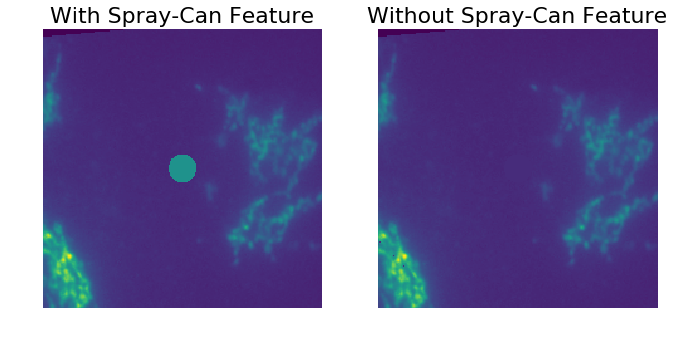

In [76]:
# From the entire image, select the region of interest.
firstROI = getROIpixels(imarray, spraypaintcenters[0])

# Remove the spray-can feature from the region of interest
ROInospray = removeSprayCanFeature(imagearray=firstROI, spraycanvalue=sprayvalue)

## Plotting under this line ##
fig, ax = plt.subplots(1,2, figsize=(11,11))

ax[0].imshow(firstROI)
ax[0].set_title('With Spray-Can Feature')
ax[0].set_axis_off()

ax[1].imshow(ROInospray)
ax[1].set_title('Without Spray-Can Feature')
ax[1].set_axis_off()

Now that our ROI is corrected, we can start processing it.

We will take a look at a handful of different image thresholding techniques:
- Otsu's method
- Yen
- Li

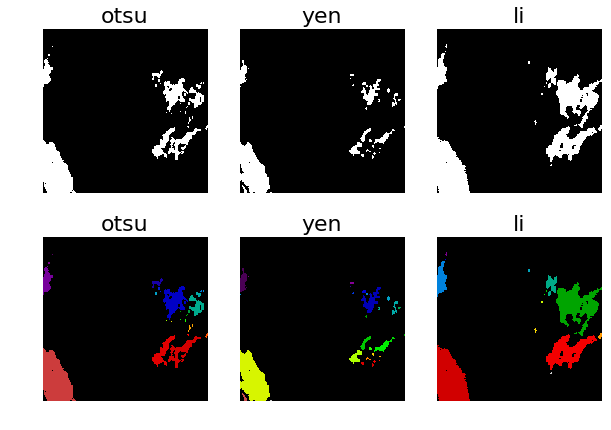

In [77]:
from skimage import filters
from skimage import measure

val_otsu = filters.threshold_otsu(ROInospray)
val_yen = filters.threshold_yen(ROInospray)
val_li  = filters.threshold_li(ROInospray)

names = ['otsu', 'yen', 'li']
methods = [val_otsu, val_yen, val_li]

ALL_labels = []
masks = []

for method in methods:
    mask = ROInospray > method
    masks.append(mask)

    all_labels = measure.label(mask, connectivity=2, background=0)
    ALL_labels.append(all_labels)


## Plotting under this line ##
fig, ax = plt.subplots(2, 3, figsize=(10,7))
ax=ax.ravel()

for i, name in enumerate(names):
    ax[i].imshow(masks[i], cmap='gray')
    ax[i+3].imshow(ALL_labels[i], cmap='nipy_spectral')

    ax[i].set_title(name)
    ax[i+3].set_title(name)
    ax[i].grid('off')
    ax[i+3].grid('off')
    ax[i].set_axis_off()
    ax[i+3].set_axis_off()

After discussion with Cynthia, the postdoc/domain expert, we chose to go with Otsu's method since its segmentation aligns well with the Golgi.

We notice that the golgi appears to be disjointed even though it's all one thing. We can use DBSCAN to combine them into one cluster.


Estimated number of clusters: 3
Unique labels: {0, 1, 2, -1}


Text(0.5,1,'Estimated number of clusters: 3')

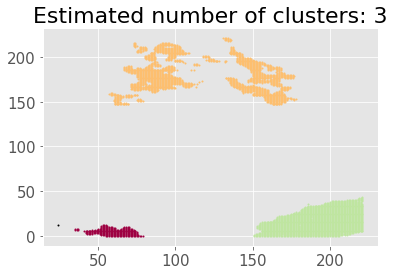

In [78]:
otsu_mask = ROInospray > val_otsu

# At this point otsu_mask is a 2D boolean array
# We must convert it into x,y pairs
xotsu, yotsu = np.where(otsu_mask==True)
XYotsu = np.array((xotsu, yotsu)).T

## Start DBSCAN
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=10, min_samples=10).fit(XYotsu)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)

print('Estimated number of clusters: {}'.format(n_clusters_))
print('Unique labels: {}'.format(unique_labels))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = XYotsu[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), markersize=1)

    xy = XYotsu[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

plt.title('Estimated number of clusters: %d' % n_clusters_)

Recall that the image-coordinate system has the origin at top-left with y increasing down. A (clockwise) 90-degree rotation is needed to go from this "normal" convention back to image-convention

For example, in this coordinate system, higher y-values are actually "more to the right" in the image-convention

Since these cells were chosen as edge cases and the wound is to the right, we can exploit this knowledge to select the correct cluster. 

I will do calculations here and rotate the final image.
You can do whatever makes you happy.


In [79]:
# Get the clusters into an easily slicable variable
XYclusters = [XYotsu[labels == label] for label in unique_labels
             if label != -1] # Ignore the noise labels

# Determine the desired Golgi
# knowing that the one we want will have
# the highest Y-value in this coordinate system
maxY = [np.max(cluster[:,1]) for cluster in XYclusters]
golgi = XYclusters[np.argmax(maxY)]

unweighted centroid:[ 117.17479301  179.49908004]
25.357536
95.0454934498
(117.17479300827966, 179.49908003679852)


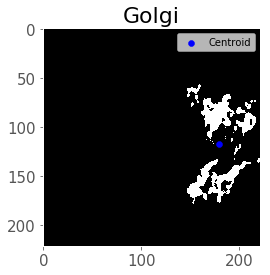

In [80]:
golgimean = golgi.mean(axis=0)
print('unweighted centroid:{}'.format(golgimean))

tobefilled = np.zeros_like(ROInospray)
tobefilled[golgi[:,0], golgi[:,1]] = 1
golgirotated = np.rot90(tobefilled, 0)

# Obtain Golgi properties. 
properties = measure.regionprops(golgirotated, cache=False)[0]

area, perimeter, centroid = [properties[key] 
            for key in ['area', 'perimeter','centroid']]

MICRONS_PER_PIXEL = 0.108

print(area*MICRONS_PER_PIXEL**2)
print(perimeter*MICRONS_PER_PIXEL)
print(centroid)



## Plotting under this line ##

plt.imshow(golgirotated, label='Nucleus', cmap='gray')
# note that the centroid's x and y are switched
plt.scatter(centroid[1], centroid[0], c='b', label='Centroid')
plt.grid('off')
plt.title('Golgi')
plt.legend()

In [82]:
#def getGolgiValues(green_image_array, spray_can_value, )

### Determining centroid of a nucleus



In [83]:
blueimarray = imarrayGBR[:,:,1]
print(blueimarray.dtype, blueimarray.shape, blueimarray.min(), blueimarray.max())

uint16 (2044, 2048) 0 14237


In [84]:
def obtainNucleusCentroids(spray_paint_centers, blue_image_array):
    """Returns a numpy array of nucleus centroids
    
    Keyword arguments
    --------------------
    spray_paint_centers: [1D array with elements [x,y]]
        1D array containing the pixel locations of various ROI centers
        
    blue_image_array: [2D image array]
        2D image array
        
    Uses Otsu's Method for image segmentation.
    """
    
    n_cells = len(spray_paint_centers)
    nucleus_centroids = []
    blueimagearray = np.array(blue_image_array)
    
    for i, cell in enumerate(spray_paint_centers):
        #print(i, cell)
        blue_ROI = getROIpixels(blueimagearray, cell)
        
        ## Check for 
        #print(np.min(blue_ROI), np.max(blue_ROI))
        #plt.imshow(blue_ROI)
        blue_val_otsu = filters.threshold_otsu(blue_ROI)
        blue_mask = blue_ROI > blue_val_otsu
        
        blue_all_labels = measure.label(blue_mask, connectivity=2)
        blue_properties = measure.regionprops(label_image = blue_all_labels)
        
        blue_areas = [prop.area for prop in blue_properties]
        
        blue_largest_index = np.argmax(blue_areas)
        
        blue_largest_centroid = blue_properties[blue_largest_index].centroid
        #plt.scatter(blue_largest_centroid[0], blue_largest_centroid[1], c='white')
        nucleus_centroids.append(blue_largest_centroid)

    return np.array(nucleus_centroids)

In [85]:
## Check to see if there are overlapping nuclei that could throw off the centroid 
## (see 'Animal 1_4hrs_002-edit.tif')

#def checkForNonRoundness(imagearray):
    

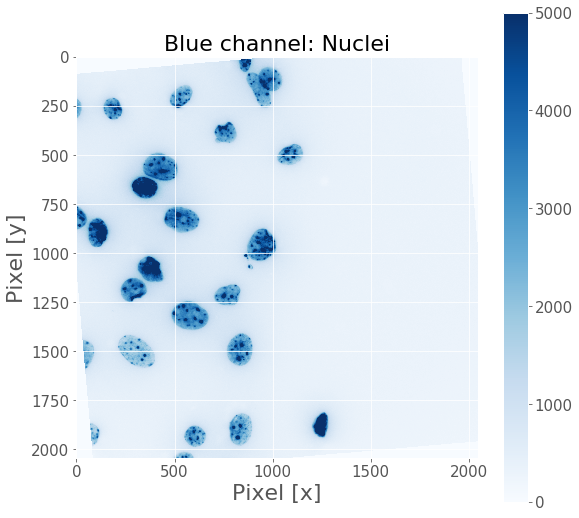

In [86]:
showimage(blueimarray, color='blue', title='Blue channel: Nuclei', vmax=5000)

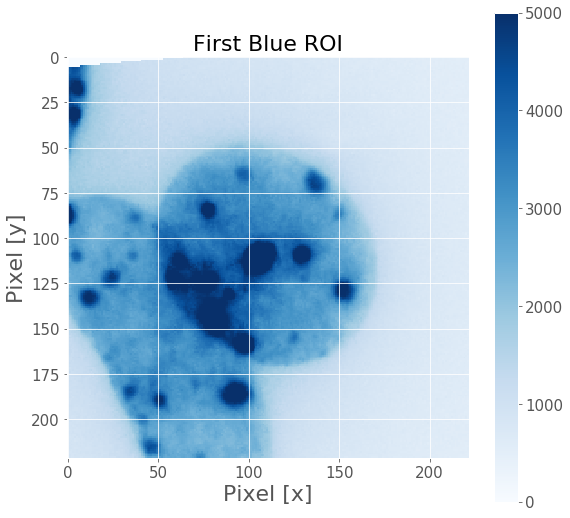

In [87]:
firstblueROI = getROIpixels(blueimarray, spraypaintcenters[0])
showimage(firstblueROI, color='blue', title='First Blue ROI', vmax=5000)

## Overlapping nuclei require image segmentation
We have overlapping nuclei. Instead of crying and/or ignoring this region, let's get to work.

First we'll do a binary segmentation to separate foreground from background.

Then we'll hit 'em with a watershed segmentation to separate the objects.

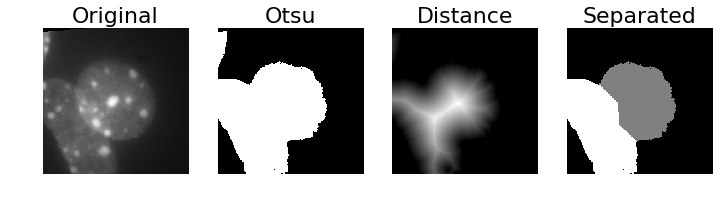

In [88]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# Use Otsu's Method to separate foreground from background
val_otsu_blue = filters.threshold_otsu(firstblueROI)
binarymaskblue = firstblueROI > val_otsu_blue

# Apply Euclidean Distance Transform to the binary image
firstbluedistance = ndi.distance_transform_edt(binarymaskblue)

# Obtain the local maxima using distance to the background
firstbluelocalmaxi = peak_local_max(firstbluedistance,
                                    min_distance=23, # ~ cell radius in pixels
                                    exclude_border=True,
                                    indices=False,
                                    labels=binarymaskblue)

# Mark the maxima
firstbluemarkers, nfeatures = ndi.label(firstbluelocalmaxi)

# Apply watershed segmentation. Don't forget about the negative!
# The negative is important because `watershed` expects minima
firstbluelabels = watershed(-firstbluedistance, firstbluemarkers,
                           mask = binarymaskblue)


## Plotting under this line ##

# Group for plotting
firstbluetitles = ['Original', 'Otsu', 'Distance','Separated']
firstbluetoplot = [firstblueROI, binarymaskblue, firstbluedistance, firstbluelabels]

fig, axes = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True,
                        subplot_kw={'adjustable':'box-forced'})
ax = axes.ravel()

for i in range(len(ax)):
    ax[i].axis('off')
    ax[i].imshow(firstbluetoplot[i], cmap=plt.cm.gray)
    ax[i].set_title(firstbluetitles[i])

Now that we have separate regions, we can calculate centroids and also determine which region is the desired nucleus.

We know that our nucleus is going to be near the center of our image, so let's calculate the centroid for each region.


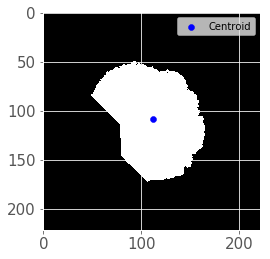

In [89]:
## Get the pixel indices for the desired nucleus
x, y = np.where(firstbluelabels==1)

X = np.array((x,y)).T

cent = X.mean(axis=0)
#print("centroid: {}".format(cent))

tobefilled = np.zeros_like(firstblueROI)
tobefilled[X[:,0], X[:,1]] = 1
X = np.rot90(tobefilled, 0)

## Plotting under this line ##

plt.imshow(X, label='Nucleus', cmap='gray')
plt.scatter(cent[1], cent[0], c='b', label='Centroid')

plt.legend()

In [90]:
props = measure.regionprops(X, cache=False)
#### Don't forget to convert these to microns at the end
print(props[0]['area']*MICRONS_PER_PIXEL**2, props[0]['perimeter'])

108.918432 425.244732728


In [91]:
bluecent = obtainNucleusCentroids(spraypaintcenters, blueimarray)
bluecent

## These pixel values are relative to the spraypaint centers

array([[ 131.25290401,   79.47457713],
       [ 105.88695557,   93.34504268],
       [ 107.46657284,  114.59347877],
       [ 106.86481047,  113.33931567]])

In [92]:
spraypaintcenters

array([[ 114,  992],
       [ 500, 1108],
       [ 964,  942],
       [1880, 1246]])

In [93]:
import numpy as np
import numpy.linalg as LA

def determineAnglesFromPoints(A, B, origin):
    """ Returns the angles [rad] between two points.
    
    Keyword arguments:
    A: a 1-D numpy array with elements in the form [x,y]
    B: a 1-D numpy array with elements in the form [x,y]
    origin: a 1-D numpy array with elements in the form [x,y]
    
    We use the dot product between two Euclidean vectors A and B
    to determine the angle between them.
    """
    A_vectors = A - origin
    B_vectors = B - origin
    
    magA = LA.norm(A_vectors, axis=1)
    magB = LA.norm(B_vectors, axis=1)
    
    dotAB = np.sum(A_vectors*B_vectors, axis=1)
    cosTheta = dotAB / (magA*magB)
    
    return np.arccos(cosTheta)

In [94]:
import numpy as np
import numpy.linalg as LA
### Importing tiff stack images with skimage.io.imread
from skimage import io

#imdir = 'C:/Users/letmedoit/endothelial Polarization-exp 1/Animal 1- 4hrs-marked/'
import glob

def main():
    ### Given a directory, get all of the image files.
    main_dir = 'C:/Users/letmedoit/endothelial Polarization-exp 1/'
    data_dir = main_dir + 'processeddata/'
    imagefiles = glob.glob(data_dir + '**/*.tif')
    # The result is a list filled with strings like
    #['.../processeddata\\Animal-1-2hrs-marked\\Animal 1_2hrs_003-edit.tif', ...]

    imagefiles = [imagefile.replace('\\', '/')
                  for imagefile in imagefiles]
    #['.../processeddata/Animal-1-2hrs-marked/Animal 1_2hrs_003-edit.tif', ...]

    ### Initialize the lists for holding output data
    nuclei_centroids = []
    golgi_centroids = []
    spray_paint_centroids = []
    image_ID = []
    golgi_area = []
    golgi_perimeter = []
    hours = []
    
    
    ### loop through the images
    '''for image in imagefiles:
        imagearrayGBR = io.imread(image)
        
        greenarray = imarrayGBR[:,:,0]
        bluearray = imarrayGBR[:,:,1]
        #redarray can sit around and look pretty
        
        nuclei_centroids.append(imagenucleicentroids)
        golgi_centroids.append(imagegolgicentroids)
        
    
    nuclei_centroids = np.array(nuclei_centroids)
    golgi_centroids = np.array(golgi_centroids)
    
    angles = determineAnglesFromPoints(nuclei_centroids,
                                        golgi_centroids,
                                        spray_paint_centroids)
    
    
    ### Combine the data into a dataframe
    d = {'imageID' : image_ID,
        'nucleiCentroidsInPixels' : nuclei_centroids,
        'golgiCentroidsInPixels' : golgi_centroids,
        'ROICentroidsInPixels' : spray_paint_centroids,
        'golgiAreaInMicronSquared' : golgi_area,
        'golgiPerimeterInMicronSquared' : golgi_perimeter
        'angle' : angles}
    df = pd.DataFrame(data=d)
    
    ### Write data to csv file
    csvfilename = 'C:/Users/letmedoit/endothelial Polarization-exp 1/data.csv'
    df.to_csv(csvfilename)
    
    ### Scatter matrix, etc.
    '''
if __name__ == '__main__':
    main()

In [95]:
testA = np.array([[0.5, 0.4], [0.8, 1], [0.35, 0.22]])
testB = np.array([[0.2, 0.1], [0.3, 0.6], [0.32,0.43]])
origins = np.zeros_like(testA)

determineAnglesFromPoints(testA, testB, origins)

array([ 0.21109333,  0.21109333,  0.36986313])